In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wandb

In [2]:
def get_project_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

In [3]:
LABEL_MAP = {
    "test_acc": "Test accuracy",
    "test_smape": "Test SMAPE",
    "rel_residual": "Relative residual",
}

In [4]:
def plot_results(entity_name, dataset, metric, ylim=None):
    project_name = f"performance_full_krr_{dataset}"
    runs = get_project_runs(entity_name, project_name)

    runs_to_plot = []
    for run in runs:
        config = run.config
        if config["opt"] == "pcg":
            if config["precision"] == "float64":
                if not (config["precond_params"]["type"] == "nystrom" and config["precond_params"]["rho"] == "regularization"):
                    runs_to_plot.append(run)
        elif config["opt"] == "askotchv2":
            if config["accelerated"]:
                if config["precond_params"] is not None:
                    if config["precond_params"]["type"] == "nystrom" and config["precond_params"]["rho"] == "damped":
                        runs_to_plot.append(run)
                        
    plot_fn = plt.semilogy if metric in ["test_smape", "rel_residual"] else plt.plot
    plt.figure()
    for run in runs_to_plot:
        history = run.scan_history(keys=[metric, "_step"])
        y = np.array([entry[metric] for entry in history])
        steps = np.array([entry["_step"] for entry in history])

        times = run.scan_history(keys=["iter_time"])
        times = np.array([entry["iter_time"] for entry in times])
        cum_times = np.cumsum(times)

        config = run.config
        label = ""
        color = None # Based on the optimizer
        marker = None # Based on the preconditioner
        linestyle = None # Based on the sampling method
        markevery = None
        if config["opt"] == "pcg":
            color = "tab:blue"
            markevery = 1
            label += "PCG"
        elif config["opt"] == "askotchv2":
            color = "tab:orange"
            markevery = 15
            label += "ASkotchV2"
        
        if config["precond_params"]["type"] == "nystrom":
            marker = "o"
            label += f', {config["precond_params"]["type"]}, {config["precond_params"]["rho"]}'
        elif config["precond_params"]["type"] == "partial_cholesky":
            if config["precond_params"]["mode"] == "greedy":
                marker = "s"
            elif config["precond_params"]["mode"] == "rpc":
                marker = "v"
            label += f', {config["precond_params"]["type"]}, {config["precond_params"]["rho"]}, {config["precond_params"]["mode"]}'

        if "sampling_method" in config:
            if config["sampling_method"] == "uniform":
                linestyle = "-"
                label += f', {config["sampling_method"]}'
            elif config["sampling_method"] == "rls":
                linestyle = "--"
                label += f', {config["sampling_method"]}'

        plot_fn(cum_times[steps], y, label=label, color=color, marker=marker,
                 markevery=markevery, linestyle=linestyle)

    plt.xlabel("Time (s)")
    plt.ylabel(LABEL_MAP[metric])
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(dataset)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.savefig(f"{dataset}_{metric}.pdf", bbox_inches="tight")
    plt.show()

In [5]:
entity_name = "sketchy-opts"
datasets = ["uracil", "qm9", "miniboone", "uracil", "qm9", "miniboone"]
metrics = ["test_smape", "test_smape", "test_acc", "rel_residual", "rel_residual", "rel_residual"]
ylims = [None, None, [0.9, 0.92], None, None, None]

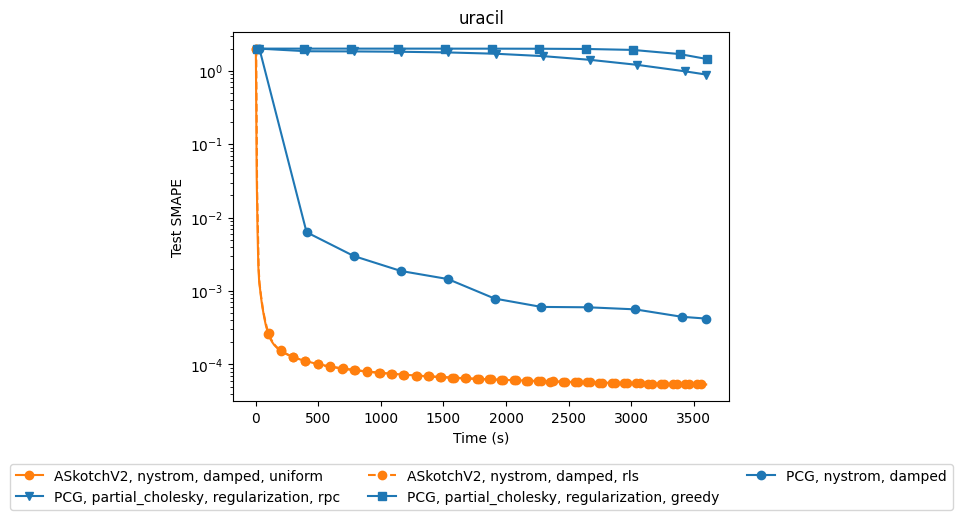

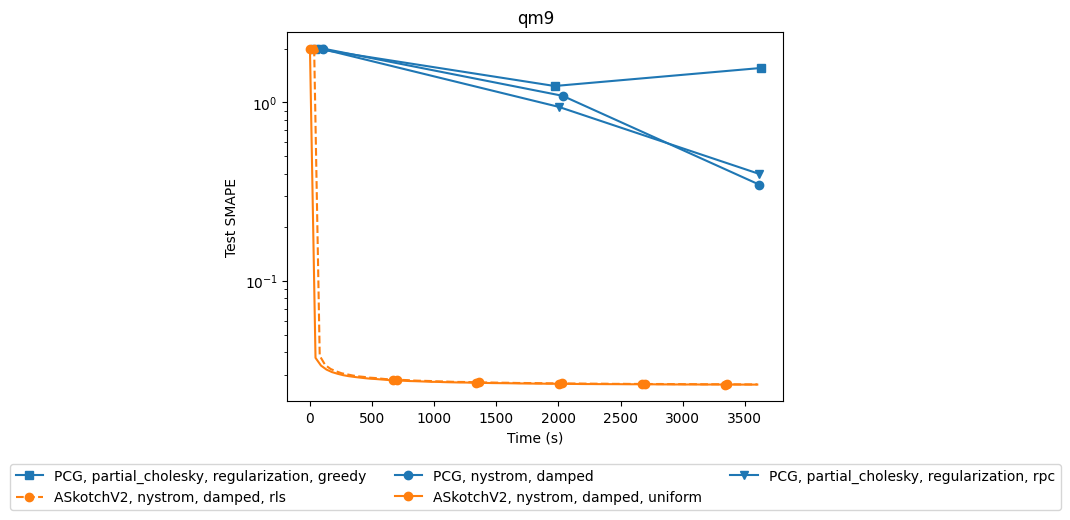

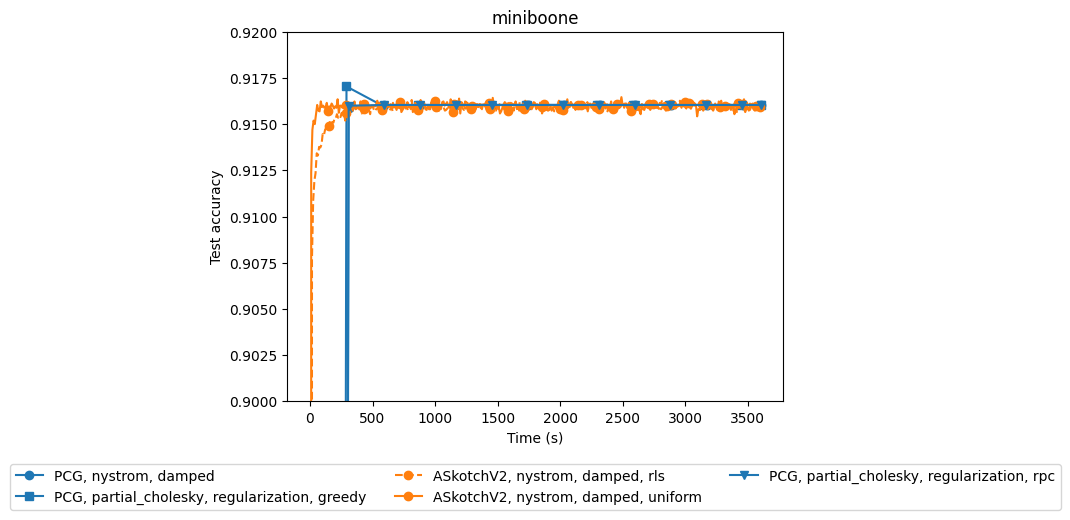

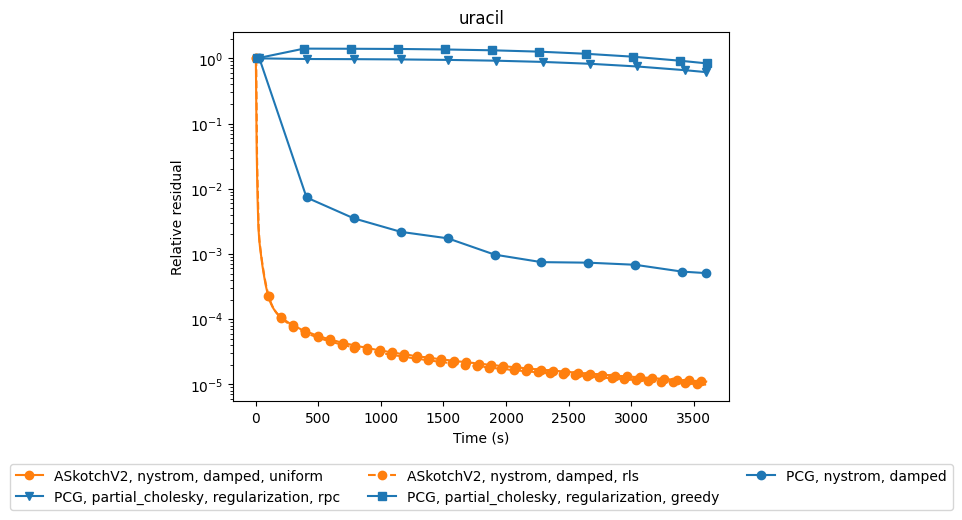

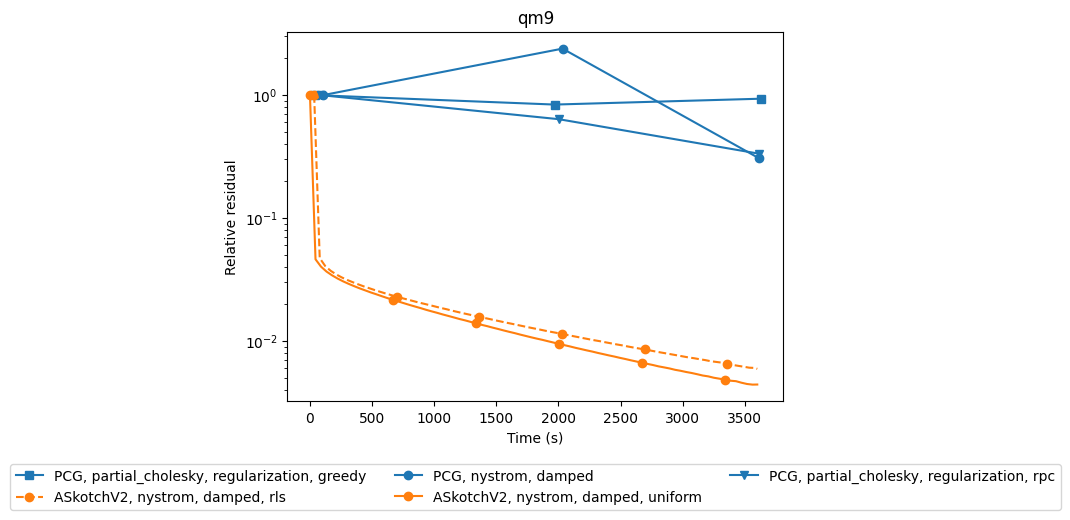

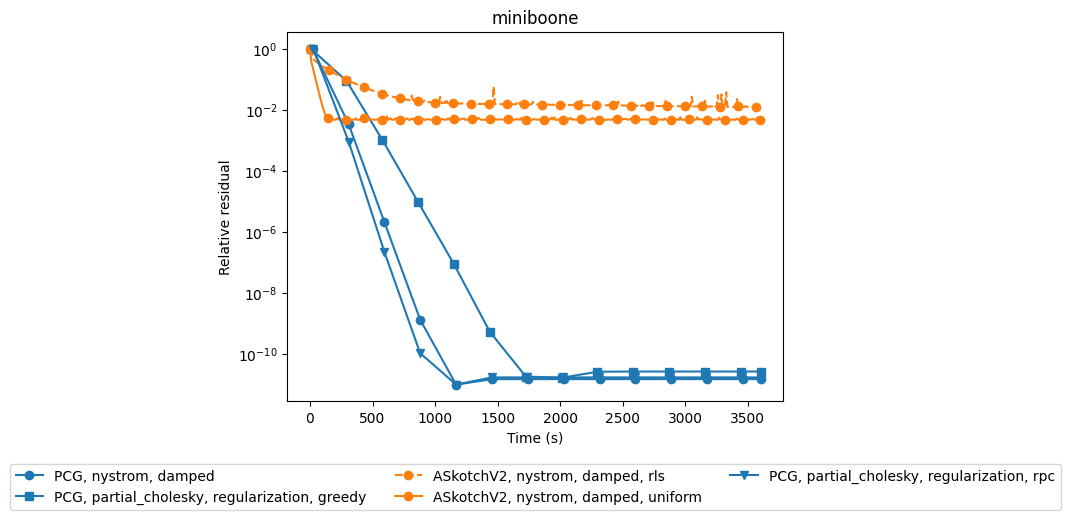

In [6]:
for dataset, metric, ylim in zip(datasets, metrics, ylims):
    plot_results(entity_name, dataset, metric, ylim)